In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

import cooler
import bioframe

import random

import pyBigWig
from scipy import stats

In [2]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [3]:
def closest_chromHMM_downsample_bed3(HMM,bed3,samplingN):
    HMM_size = []
    names_unique = sorted(HMM['name'].unique())
    for i in names_unique:
        HMM_i = HMM[HMM['name']==i].reset_index()
        HMM_size.append(len(HMM_i))
        print(i,len(HMM_i))
    sampleSize=np.min(HMM_size)
    print(sampleSize)

    HMM_distance_lst = []
    for i in names_unique:
        HMM_i = HMM[HMM['name']==i].reset_index()
        HMM_i_rlst = []
        for r in range(samplingN):
            HMM_i_subsample = random.sample(range(len(HMM_i)),sampleSize)
            x = bioframe.closest(bed3,HMM_i)
            HMM_i_rlst.append(x.distance)
        HMM_distance_lst.append(np.concatenate(HMM_i_rlst))

    return(HMM_distance_lst)

In [4]:
chromHMM_D = bioframe.read_table('/home/kimj50/cohesin_paper/_notebook_v1/output/chromHMM/Daugherty/Supplemental_Table_S10.txt',schema='bed4')
chromHMM_E = bioframe.read_table('/home/kimj50/cohesin_paper/_notebook_v1/output/chromHMM/Evans/pnas.1608162113.sd01.txt',schema='bed4')
jets = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb.bed',schema='bed4')


jets['chrom'] = 'chr'+jets['chrom']
jets['start'] = jets['start']+1000
jets['end'] = jets['end']-999
jets

chromHMM_E['chrom'] = 'chr'+chromHMM_E['chrom']


In [5]:
D = closest_chromHMM_downsample_bed3(chromHMM_D,jets,10)
E = closest_chromHMM_downsample_bed3(chromHMM_E,jets,10)

Active enhancer 16262
H3K27me3 repressed 25552
Heterochromatin 9754
Low signal 48016
Repressed enhancer 12966
TSS/Promoter 11368
Transcribed gene body 45871
9754
1 5086
2 3196
3 5344
4 3029
5 3683
6 7118
7 20586
8 3756
9 5017
10 6538
11 5113
12 18035
13 4726
14 3889
15 11825
16 20934
17 6045
18 7937
19 5631
20 5676
3029


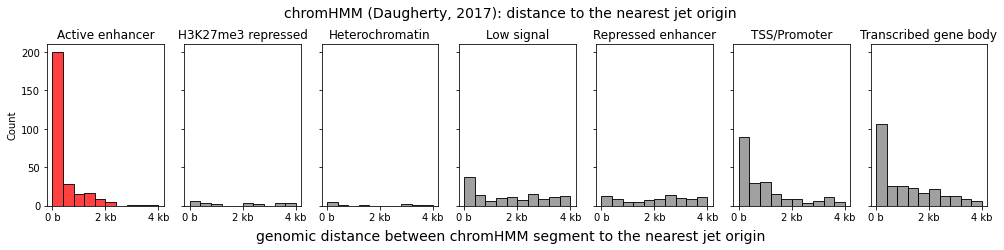

In [6]:
#C = ['black','grey','blue','green','pink','purple','magenta']
C = ['red']+['grey']*6
L = sorted(chromHMM_D['name'].unique())
t = D

bigFont = 14
f, axs = plt.subplots(
    figsize=(14, 3),
    nrows=1,
    ncols=7,
    sharey='row',
    sharex='row'
)



for i in range(len(t)):
    t_i = t[i]
    t_i_sub = t_i[t_i<=4_000]
    sns.histplot(t_i_sub,ax=axs[i],color=C[i],stat='count',fill=True,binwidth=400)
    axs[i].set_title(label=L[i])
    axs[i].set_xlabel('')
    
    format_ticks(axs[i],y=False,rotate=False)

    plt.yticks(np.array([0,500,1000,1500,2000]), np.array([0,500,1000,1500,2000])//10)

f.text(0.51, 1, 'chromHMM (Daugherty, 2017): distance to the nearest jet origin', ha='center',fontsize=bigFont)

f.text(0.51, -0.03, 'genomic distance between chromHMM segment to the nearest jet origin', ha='center',fontsize=bigFont)

plt.tight_layout()

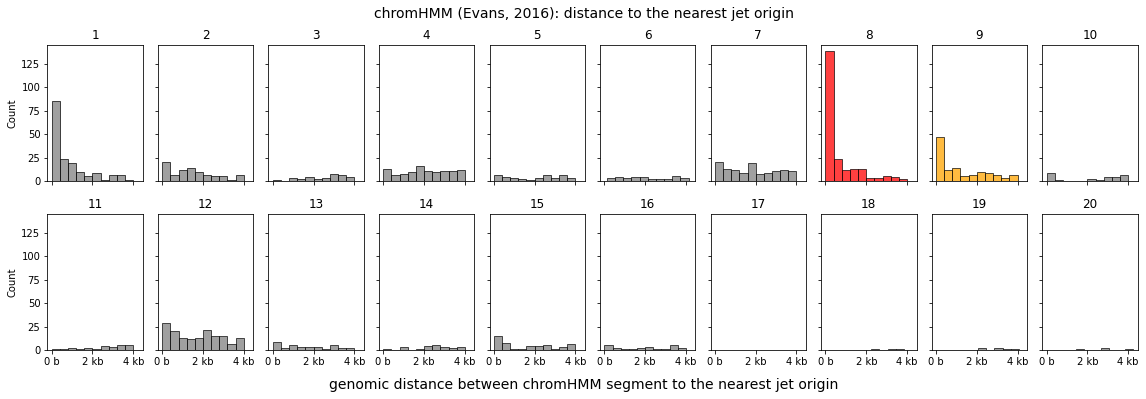

In [7]:
C = ['grey']*7+['red','orange']+['grey']*11
L = sorted(chromHMM_E['name'].unique())
t = E

f, axs = plt.subplots(
    figsize=(16, 5),
    nrows=2,
    ncols=len(L)//2,
    sharey=True,
    sharex=True
)

for i in range(0,10):
    t_i = t[i]
    t_i_sub = t_i[t_i<=4000]
    ax = sns.histplot(t_i_sub,ax=axs[0,i],color=C[i],stat='count',binwidth=400,fill=True)
    ax.set_title(label=L[i])
    ax.set_xlabel('')
    format_ticks(ax,y=False,rotate=False)
    plt.yticks(np.array([0,250,500,750,1000,1250]), np.array([0,250,500,750,1000,1250])//10)

    
for i in range(10,20):
    t_i = t[i]
    t_i_sub = t_i[t_i<=4000]
    ax = sns.histplot(t_i_sub,ax=axs[1,i-10],color=C[i],stat='count',binwidth=400,fill=True)
    ax.set_title(label=L[i])
    ax.set_xlabel('')
    format_ticks(ax,y=False,rotate=False)
    plt.yticks(np.array([0,250,500,750,1000,1250]), np.array([0,250,500,750,1000,1250])//10)
    
    
f.text(0.51, 1, 'chromHMM (Evans, 2016): distance to the nearest jet origin', ha='center',fontsize=bigFont)
f.text(0.51, -0.03, 'genomic distance between chromHMM segment to the nearest jet origin', ha='center',fontsize=bigFont)

plt.tight_layout()

In [8]:
def jets_vs_ChIP(jets_bed4,Peaks_bed3,BW,jet_flank):
    mids = (jets_bed4['end']+jets_bed4['start'])/2
    
    vals = []
    for i in range(len(jets_bed4)):
        a = 'chr'+jets_bed4['chrom'][i]
        b = mids[i]-jet_flank
        if b<0:
            b=0
        c = mids[i]+jet_flank
        if c>BW.chroms(a):
            c=a
        v = BW.stats(a,int(b),int(c),type='mean',nBins=1)
        vals.append(v)
#    print(len(jets_bed4),len(vals))
    d = {'val': np.hstack(vals)}
    df = pd.concat([jets_bed4, pd.DataFrame(d)], axis=1)
    
    #### add column quantiling jet strength ###
    df['q_name'] = 'q'
    q1 = df['name']<=np.quantile(df['name'], 0.25)
    q2 = np.logical_and(df['name']>np.quantile(df['name'], 0.25),df['name']<=np.quantile(df['name'], 0.5))
    q3 = np.logical_and(df['name']>np.quantile(df['name'], 0.5),df['name']<=np.quantile(df['name'], 0.75))
    q4 = df['name']>np.quantile(df['name'], 0.75)
    print(len(df),q1.sum(),q2.sum(),q3.sum(),q4.sum())
    
    df.loc[q1, ['q_name']] = 'q1'
    df.loc[q2, ['q_name']] = 'q2'
    df.loc[q3, ['q_name']] = 'q3'
    df.loc[q4, ['q_name']] = 'q4'
    
    ################## npeaks per jet-range #################
    df_range = {'chrom': 'chr'+df['chrom'], 'start': df['start']-jet_flank, 'end': df['end']+jet_flank}
    df_r = pd.DataFrame(data=df_range)
    
    
    nPeaks = bioframe.count_overlaps(df_r,Peaks_bed3)['count']
    out = pd.concat([df, pd.DataFrame(nPeaks)], axis=1)
    return(out)

In [9]:
plus = pyBigWig.open("/home/kimj50/cohesin_paper/other_chips/groseq_N2_L3_avg_WS230_RPKM_plus.bw")
minus = pyBigWig.open("/home/kimj50/cohesin_paper/other_chips/groseq_N2_L3_avg_WS230_RPKM_minus.bw")

In [10]:
# jets
jets_annot = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb.bed',schema='bed4')

# nipbl
bw_pol2 = pyBigWig.open("/home/kimj50/cohesin_paper/other_chips/8WG16_CA1200_1hrauxin_L3_AKM159_AKM256_ext415_ext467_inputsubt_avgFIX.bw")
pol2_p = bioframe.read_table("/home/kimj50/cohesin_paper/other_chips/8WG16_CA1200_1hrauxin_avg_AKM159_AKM256_chip_peaks.bed",schema='bed12').iloc[:,range(3)]


dat = jets_vs_ChIP(jets_annot,pol2_p,bw_pol2,3000)


287 72 72 71 72


0.5
0.58


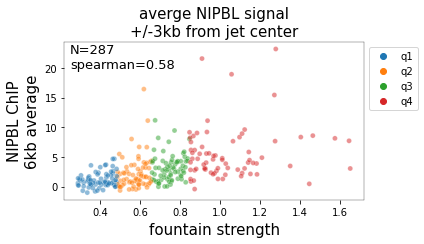

In [11]:
f, axs = plt.subplots(
    figsize=(6, 3.5),
    nrows=1,
    ncols=1,
    sharex=True,
    sharey='row'
)
bigFont = 15

Pcorr = dat['name'].corr(dat['val'],method='pearson')
Scorr = dat['name'].corr(dat['val'],method='spearman')
print(round(Pcorr, 2))
print(round(Scorr, 2))
sns.scatterplot(ax=axs,data=dat, x="name", y="val",hue='q_name',
                hue_order=('q1','q2','q3','q4'),alpha=0.5,s=25)
axs.set_title("averge NIPBL signal\n+/-3kb from jet center",size=bigFont)

plt.text(0.25, 20., "N="+str(len(dat))+"\nspearman="+str(round(Scorr,2)),fontsize=bigFont-2)


axs.set_ylabel("NIPBL ChIP\n6kb average",rotation=90,fontsize=bigFont, labelpad=5)
axs.set_xlabel("fountain strength",fontsize=bigFont, labelpad=5)
axs.legend(loc = 2, bbox_to_anchor = (1,1))

for axis in ['top', 'bottom', 'left', 'right']:
    axs.spines[axis].set_linewidth(0.3)
plt.tight_layout()

In [12]:
jets = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb.bed',schema='bed6')
jets['chrom']='chr'+jets.chrom
jets['mid']=jets.start+1000

In [13]:
#### loop over flank size ####

flanks_kb = [1,5,10,20,30,40]
flanks_kb = [*range(1,42,3)]
pcorr_lst = []
for f in range(len(flanks_kb)):

    flank = flanks_kb[f]*1_000
    print(f,flank)
    p_lst = []
    m_lst = []
    for i in range(len(jets)):
        p=plus.stats(jets.chrom[i],jets.mid[i]-flank,jets.mid[i]+flank,type='mean')[0]
        m=minus.stats(jets.chrom[i],jets.mid[i]-flank,jets.mid[i]+flank,type='mean')[0]
        p_lst.append(p)
        m_lst.append(m)
    avg=np.nanmean([np.array(p_lst,dtype='float'),np.array(m_lst,dtype='float')],axis=0)
    p_corr = stats.spearmanr(jets.name,avg)[0]
    pcorr_lst.append(p_corr)


0 1000
1 4000
2 7000
3 10000
4 13000
5 16000
6 19000
7 22000
8 25000
9 28000
10 31000
11 34000
12 37000
13 40000


/ext3/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


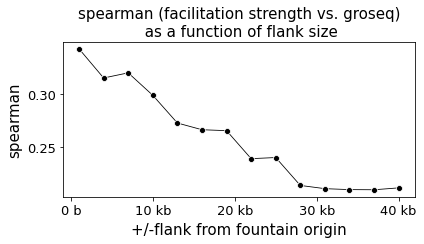

In [14]:
f, axs = plt.subplots(
    figsize=(6, 3.5),
    nrows=1,
    ncols=1,
    sharex=True,
    sharey='row'
)
bigFont = 15

sns.lineplot(np.array(flanks_kb)*1_000,pcorr_lst,color='black',marker='o',markersize=6,linewidth=0.8)
format_ticks(axs,y=False,rotate=False)

plt.xticks(fontsize=13,)
axs.locator_params(axis='x', nbins=5)
plt.yticks(fontsize=13,)
axs.locator_params(axis='y', nbins=5)

axs.set_ylabel("spearman",rotation=90,fontsize=bigFont, labelpad=5)
axs.set_xlabel("+/-flank from fountain origin",fontsize=bigFont, labelpad=5)
axs.set_title("spearman (facilitation strength vs. groseq)\n as a function of flank size",size=bigFont)
plt.tight_layout()

In [15]:

def find_pair_d(chromHMM_df, name1, name2):
    n1 = chromHMM_df[chromHMM_df.name==name1].copy()
    n2 = chromHMM_df[chromHMM_df.name==name2].copy()
    n1['mid']=n1['start']+n1['end'] / 2
    n1['mid1']=n1.mid+1
    n2['mid']=n2['start']+n2['end'] / 2
    n2['mid1']=n2.mid+1
    c = bioframe.closest(n1,n2,cols1=['chrom','mid','mid1'],cols2=['chrom','mid','mid1'])
    return c

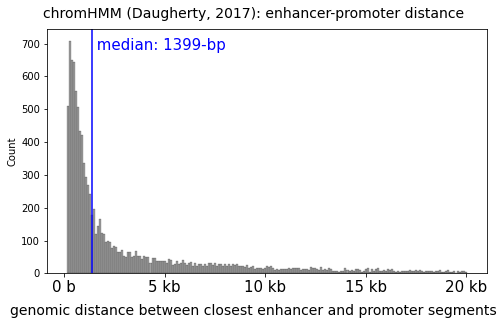

In [16]:
bigFont = 14
f, axs = plt.subplots(
    figsize=(7, 4),
    nrows=1,
    ncols=1,

)



t = find_pair_d(chromHMM_D,'TSS/Promoter','Active enhancer')
MEAN = np.mean(t.distance)
MED = np.median(t.distance)
td = t.distance[t.distance<20_000]
p = sns.histplot(td,ax=axs,color='grey',stat='count',fill=True,binwidth=100)
#axs.axvline(x=MEAN,color='red')
axs.axvline(x=MED,color='blue')
#axs.text(x=MEAN,y=p.get_ylim()[1]*.90,s=' mean: '+str(int(MEAN))+'-bp',
#         horizontalalignment='left',verticalalignment='bottom',fontsize=15,color='red')
axs.text(x=MED,y=p.get_ylim()[1]*.90,s=' median: '+str(int(MED))+'-bp',
         horizontalalignment='left',verticalalignment='bottom',fontsize=15, color='blue')

axs.set_xlabel('')

format_ticks(axs,y=False,rotate=False)
plt.xticks(fontsize=15,)
axs.locator_params(axis='x', nbins=5)
#    plt.yticks(np.array([0,500,1000,1500,2000]), np.array([0,500,1000,1500,2000])//10)

f.text(0.51, 1, 'chromHMM (Daugherty, 2017): enhancer-promoter distance', ha='center',fontsize=bigFont)

f.text(0.51, -0.03, 'genomic distance between closest enhancer and promoter segments', ha='center',fontsize=bigFont)

plt.tight_layout()

In [18]:
def find_pair_d(chromHMM_df, name1, name2a, name2b):
    n1 = chromHMM_df[chromHMM_df.name==name1].copy()
    n2 = chromHMM_df[np.logical_or(chromHMM_df.name==name2a,chromHMM_df.name==name2b)].copy()
    n1['mid']=n1['start']+n1['end'] / 2
    n1['mid1']=n1.mid+1
    n2['mid']=n2['start']+n2['end'] / 2
    n2['mid1']=n2.mid+1
    c = bioframe.closest(n1,n2,cols1=['chrom','mid','mid1'],cols2=['chrom','mid','mid1'])
    return c
t = find_pair_d(chromHMM_E,1,2,3)

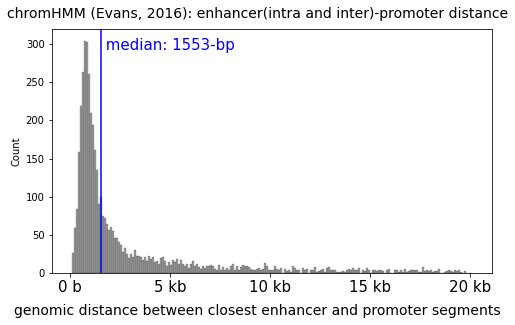

In [19]:
bigFont = 14
f, axs = plt.subplots(
    figsize=(7, 4),
    nrows=1,
    ncols=1,

)



t = find_pair_d(chromHMM_E,1,2,3)
MEAN = np.mean(t.distance)
MED = np.median(t.distance)
td = t.distance[t.distance<20_000]
p = sns.histplot(td,ax=axs,color='grey',stat='count',fill=True,binwidth=100)
#axs.axvline(x=MEAN,color='red')
axs.axvline(x=MED,color='blue')
#axs.text(x=MEAN,y=p.get_ylim()[1]*.90,s=' mean: '+str(int(MEAN))+'-bp',
#         horizontalalignment='left',verticalalignment='bottom',fontsize=15,color='red')
axs.text(x=MED,y=p.get_ylim()[1]*.90,s=' median: '+str(int(MED))+'-bp',
         horizontalalignment='left',verticalalignment='bottom',fontsize=15, color='blue')

axs.set_xlabel('')

format_ticks(axs,y=False,rotate=False)
plt.xticks(fontsize=15,)
axs.locator_params(axis='x', nbins=5)
#    plt.yticks(np.array([0,500,1000,1500,2000]), np.array([0,500,1000,1500,2000])//10)

f.text(0.51, 1, 'chromHMM (Evans, 2016): enhancer(intra and inter)-promoter distance', ha='center',fontsize=bigFont)

f.text(0.51, -0.03, 'genomic distance between closest enhancer and promoter segments', ha='center',fontsize=bigFont)

plt.tight_layout()